In [11]:
#Import neccessary libraries.
import os
import nolds
import shutup
import itertools
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi']=100 #Highres plots
import matplotlib.pyplot as plt
from typeguard import typechecked
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from mne_features.feature_extraction import FeatureExtractor
from mne_features.feature_extraction import extract_features
from sklearn.multioutput import MultiOutputClassifier

In [12]:
def check_params(q: float, redundancy: float, stages: int):
    if q < 1:
        raise ValueError("q must be greater or equal 1!")
    if redundancy <= 1:
        raise ValueError("The redundancy must be strictly greater than 1")
    if stages < 1:
        raise ValueError("stages must be a positive integer!")
from typing import Tuple

import numpy as np
from scipy.fftpack import fft, ifft

#from tqwt_tools.tqwt.check_params import check_params


def tqwt(x: np.ndarray, q: float, redundancy: float, stages: int) -> np.ndarray:
    """
    Tunable-Q Wavelet transform TODO: more docs for tqwt

    Parameters
    ----------
    x: array like, shape (n,)
        Input signal, needs to be of even length
    q: float
        Q-Factor. The Q-factor, denoted Q, affects the oscillatory behavior the wavelet; specifically, Q affects the
        extent to which the oscillations of the wavelet are sustained. Roughly, Q is a measure of the number of
        oscillations the wavelet exhibits. For Q, a value of 1.0 or greater can be specified. The definition of the
        Q-factor of an oscillatory pulse is the ratio of its center frequency to its bandwidth.
    redundancy: float
        Oversampling rate (redundancy). Redundancy of the TQWT when it is computed using
        infinitely many levels. Here `redundancy means total over-sampling rate of the transform (the total number of
        wavelet coefficients divided by the length of the signal to which the TQWT is applied.) The specified value of
        must be greater than 1.0, and a value of 3.0 or greater is recommended. (When it is close to 1.0, the wavelet
        will not be well localized in time — it will have excessive ringing which is generally considered undesirable.)
        The actual redundancy will be somewhat different than the parameter because the transform can actually be
        computed using only a finite number of levels.
    stages: int
        The number of stages (or levels) of the wavelet transform is denoted by stages. The transform consists of a
        sequence of two-channel filter banks, with the low-pass output of each filter bank being used as the input to
        the successive filter bank. The parameter `stages` denotes the number of filter banks. Each output signal
        constitutes one subband of the wavelet transform. There will be J + 1 subbands: the high-pass filter output
        signal of each filter bank, and the low-pass filter output signal of the final filter bank.

    Returns
    -------
    w: np.ndarray with dtype np.object
        Wavelet coefficients.

    Examples
    --------
    >>> # verify perfect reconstruction
    >>> import numpy as np
    >>> from tqwt_tools import tqwt
    >>> q = 4; redundancy = 3; stages = 3      # parameters
    >>> n = 200                  # signal length
    >>> x = np.random.randn(n)    # test signal (white noise)
    >>> w = tqwt(x, q, redundancy, stages)       # wavelet transform
    >>> y = itqwt(w, q, redundancy, N);      # inverse wavelet transform
    >>> max(abs(x - y))          # reconstruction error
    """
    check_params(q, redundancy, stages)
    if x.shape[0] % 2 or len(x.shape) != 1:
        raise ValueError("Input signal x needs to be one dimensional and of even length!")
    x = np.asarray(x)

    beta = float(2 / (q + 1))
    alpha = float(1 - beta / redundancy)
    n = x.shape[0]

    max_num_stages = int(np.floor(np.log(beta * n / 8) / np.log(1 / alpha)))

    if stages > max_num_stages:
        if max_num_stages > 0:
            raise ValueError("Too many subbands, reduce subbands to " + str(max_num_stages))
        else:
            raise ValueError("Too many subbands specified, increase signal length")

    fft_of_x = fft(x) / np.sqrt(n)  # unitary DFT

    w = []                          # init list of wavelet coefficients

    for subband_idx in range(1, stages + 1):
        n0 = 2 * round(alpha ** subband_idx * n / 2)
        n1 = 2 * round(beta * alpha ** (subband_idx - 1) * n / 2)
        fft_of_x, w_subband = analysis_filter_bank(fft_of_x, n0, n1)
        w.append(ifft(w_subband) * np.sqrt(len(w_subband)))  # inverse unitary DFT

    w.append(ifft(fft_of_x) * np.sqrt(len(fft_of_x)))      # inverse unitary DFT
    return np.array(w, dtype=object)


def analysis_filter_bank(x: np.ndarray, n0: int, n1: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Two-channel analysis filter bank operating on a frequency domain input x. This function is used
    iteratively by `tqwt`.

    Parameters
    ----------
    x: np.ndarray
        Input vector (frequency domain)
    n0: int
        length of the lp_subband
    n1: int
        length of the hp_subband

    Returns
    -------
    lp_subband: np.ndarray
        low-pass output of the filter bank in the frequency domain
    hp_subband: np.ndarray
        high-pass output of the filter bank in the frequency domain
    """
    x = np.array(x)
    n = x.shape[0]                  # len(x)

    p = int((n-n1) / 2)             # pass-band
    t = int((n0 + n1 - n) / 2 - 1)  # transition-band
    s = int((n - n0) / 2)           # stop-band

    # transition band function
    v = np.arange(start=1, stop=t+1) / (t+1) * np.pi
    transit_band = (1 + np.cos(v)) * np.sqrt(2 - np.cos(v)) / 2.0

    # low-pass subband
    lp_subband = np.zeros(n0, dtype=x.dtype)
    lp_subband[0] = x[0]                                                  # DC-term
    lp_subband[1:p+1] = x[1:p + 1]                                        # pass-band
    lp_subband[1+p:p+t+1] = x[1 + p:p + t + 1] * transit_band             # transition-band
    lp_subband[int(n0 / 2)] = 0                                           # nyquist
    lp_subband[n0-p-t:n0-p] = x[n - p - t:n - p] * np.flip(transit_band)  # transition-band (negative frequencies)
    lp_subband[n0-p:] = x[n - p:]                                         # pass-band (negative frequencies)

    # high-pass subband
    hp_subband = np.zeros(n1, dtype=x.dtype)
    hp_subband[0] = 0                                                     # DC-term
    hp_subband[1:t+1] = x[1 + p:t + p + 1] * np.flip(transit_band)        # transition-band
    hp_subband[t+1:s+1+t] = x[p + t + 1:p + t + s + 1]                    # pass-band
    if n // 2 == 0:                                                       # nyquist if N is even
        hp_subband[n1/2] = x[n / 2]
    hp_subband[n1-t-s-1:n1-t] = x[n - p - t - s - 1:n - p - t]            # pass-band (negative frequencies)
    hp_subband[n1-t:n1] = x[n - p - t:n - p] * transit_band               # transition-band (negative frequencies)

    return lp_subband, hp_subband
import numpy as np
from scipy.fftpack import fft, ifft


def itqwt(w: np.ndarray, q: float, redundancy: float, n: int) -> np.ndarray:
    """
    Inverse Tunable-Q Wavelet Transform

    Parameters
    ----------
    w: np.ndarray with dtype np.object
        Wavelet coefficients for inverse transform
    q: float
        Q-Factor of the `tqwt` used for the forward transform. Greater or equal than 1.
    redundancy: float
        Parameter determining overlap ov the bands, s. `tqwt` docs for more info. Greater or equal than 1.
    n: int
        length of the original time-domain signal in samples.

    Returns
    -------
    y: np.ndarray:
        Time-domain signal

    """
    w = np.array(w, dtype=object)  # behaving sort of like a cell array in matlab

    # scaling factors
    beta = 2.0 / (q + 1)
    alpha = 1.0 - beta / redundancy
    num_subbands = w.shape[0]

    y = fft(w[num_subbands-1]) / np.sqrt(w[num_subbands-1].shape[0])                  # unitary DFT

    for subband_idx in reversed(range(num_subbands-1)):
        W = fft(w[subband_idx]) / np.sqrt(len(w[subband_idx]))  # unitary DFT
        m = int(2 * round(alpha ** subband_idx * n/2))
        y = synthesis_filter_bank(y, W, m)

    return np.real_if_close(ifft(y) * np.sqrt(y.shape[0]))      # inverse unitary DFT, discard small imaginary part


def synthesis_filter_bank(lp_subband: np.ndarray, hp_subband: np.ndarray, n: int) -> np.ndarray:
    """
    Complementary function for the `analysis_filter_bank`. Used iteratively by the `itqwt`

    Parameters
    ----------
    lp_subband: np.ndarray
        Low-pass subband (frequency-domain)
    hp_subband: np.ndarray
        High-pass subband (frequency-domain)
    n: int
        Length of the output in samples (frequency-domain)
    """
    n0 = lp_subband.shape[0]
    n1 = hp_subband.shape[0]

    p = int((n - n1) / 2)            # pass-band
    t = int((n0 + n1 - n) / 2 - 1)   # transition band
    s = int((n - n0) / 2)            # stop-band

    # transition band function
    v = np.arange(start=1, stop=t + 1) / (t + 1) * np.pi
    trans = (1 + np.cos(v)) * np.sqrt(2 - np.cos(v)) / 2

    # low-pass subband
    y0 = np.zeros(n, dtype=complex)
    y0[0] = lp_subband[0]                                       # DC-term
    y0[1:p+1] = lp_subband[1:p + 1]                               # passband
    y0[1+p:p+t+1] = lp_subband[1 + p:p + t + 1] * trans               # transition-band
    y0[p+t+1:p+t+s+1] = np.zeros((p+t+s+1) - (p+t+1))         # stop-band
    if n // 2 == 0:
        y0[n/2] = 0                                           # Nyquist if even length
    y0[n-p-t-s:n-p-t] = np.zeros((n-p-t) - (n-p-t-s))         # stop-band (negative frequency)
    y0[n-p-t:n-p] = lp_subband[n0 - p - t:n0 - p] * np.flip(trans)  # transition band (negative frequencies)
    y0[n-p:] = lp_subband[n0 - p:]                                # passband (negative frequency)

    # high-pass subband
    y1 = np.zeros(n, dtype=complex)
    y1[0] = 0                                                 # DC-term
    y1[1:p+1] = np.zeros(p)                                   # stop-band
    y1[1+p:t+p+1] = hp_subband[1:t + 1] * np.flip(trans)          # transition-band
    y1[p+t+1:p+t+s+1] = hp_subband[t + 1:s + 1 + t]                   # passband
    if n // 2 == 0:
        y1[n/2] = hp_subband[n1 / 2]                              # Nyquist if N is even
    y1[n-p-t-s-1:n-p-t] = hp_subband[n1 - t - s - 1:n1 - t]             # passband (negative frequency)
    y1[n-p-t:n-p] = hp_subband[n1 - t:n1] * trans                 # transition-band (negative frequency)
    y1[n-p:n] = np.zeros(p)

    return y0 + y1


In [19]:
class EpilepsyFeatureExtractor:
    def __init__(self):
        shutup.please()
        self.base_path = '/home/hari/projects/BonnData'
        self.folders = ['A', 'B', 'D', 'E']
        self.file_prefixes = {'A': 'Z', 'B': 'O', 'D': 'F', 'E': 'S'}
        self.data_names = {folder: [] for folder in self.folders}
        
        self.arr_a = np.empty((4096, 0))
        self.arr_b = np.empty((4096, 0))
        self.arr_d = np.empty((4096, 0))
        self.arr_e = np.empty((4096, 0))
        
    def load_data(self):
        # List files in each folder
        for folder in self.folders:
            folder_path = os.path.join(self.base_path, folder)
            files = sorted(os.listdir(folder_path))
            self.data_names[folder] = [os.path.join(folder_path, f) for f in files if f.endswith('.eea')]

        # Load data from files
        for folder, arr in zip(self.folders, [self.arr_a, self.arr_b, self.arr_d, self.arr_e]):
            for file in self.data_names[folder]:
                data = pd.read_csv(file)
                data = np.array(data)
                arr = np.append(arr, data, axis=1)
            if folder == 'A':
                self.arr_a = arr
            elif folder == 'B':
                self.arr_b = arr
            elif folder == 'D':
                self.arr_d = arr
            elif folder == 'E':
                self.arr_e = arr

        # Apply denoising to the loaded data
        self.arr_a = self.denoise(self.arr_a.T)
        self.arr_b = self.denoise(self.arr_b.T)
        self.arr_d = self.denoise(self.arr_d.T)
        self.arr_e = self.denoise(self.arr_e.T)
    
    def denoise(self, arr):
        den_arr = np.empty((4096, 0))
        q = 6
        redundancy = 5
        stages = 10
        n = len(arr[0, :])
        for i in range(len(arr[:, 0])):
            x = arr[i, :]
            w = tqwt(x, q, redundancy, stages)
            y = itqwt(w, q, redundancy, n)
            y = np.array(y.real.reshape((4096, 1)))
            den_arr = np.append(den_arr, y, axis=1)
        return den_arr.T
    
    def select_samples(self):
        print(self.arr_a.shape)
        data = np.array([self.arr_a[0:80], self.arr_b[0:80], self.arr_e[0:80]]).reshape(240, 1, 4096)
        arr = data.reshape(240, 4096)        
        return arr,data
    
    def statistical_feature_extractor(self):
        _,data = self.select_samples()
        sfreq = 173.6 # Sampling frequency of the data
        selected_funcs = ['mean','std','kurtosis','skewness'] # Stastical features of the data vector
        stat_features = extract_features(data, sfreq, selected_funcs, funcs_params=None, n_jobs=1, ch_names=None, return_as_df=False) # Extracting them Using MNE package
        stat_features = stat_features.T
        
        return stat_features
        
    
    def plot_stat_features(self):
        features = self.statistical_feature_extractor()
        labels = ['Mean', 'Std', 'Kurtosis', 'Skewness']
        colors = ['black', 'red', 'blue', 'green']

        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        axs = axs.ravel()

        for i in range(4):
            axs[i].plot(features[i, :],'o',color=colors[i], label=labels[i])
            axs[i].axvline(x=160,color='orange')
            axs[i].set_xlabel('Data Vector')
            axs[i].set_ylabel(labels[i])
            axs[i].legend()

        plt.tight_layout()
        plt.show()
    
    
        
    
    def chaotic_feature_extractor(self):
        data_s,_ = self.select_samples()
        Lyaps = []
        Hurst = []
        Entropy = []
        dfa = []

        for i in tqdm(range(data_s.shape[0])):
            l = nolds.lyap_r(data_s[i, :])  # Lyapunov Exponent
            h = nolds.hurst_rs(data_s[i, :])  # Hurst Exponent
            s = nolds.sampen(data_s[i, :])  # Sample entropy
            d = nolds.dfa(data_s[i, :])  # Detrended fluctuation analysis

            Lyaps.append(l)
            Hurst.append(h)
            Entropy.append(s)
            dfa.append(d)

        features = [Lyaps, Hurst, Entropy, dfa]
        return np.array(features).T
    
    def plot_chaotic_features(self):
        features = self.chaotic_feature_extractor()
        labels = ['Lyapunov Exponent', 'Hurst Exponent', 'Sample Entropy', 'DFA']
        colors = ['black', 'red', 'blue', 'green']

        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        axs = axs.ravel()

        for i in range(4):
            axs[i].plot(features[:, i],'o',color=colors[i], label=labels[i])
            axs[i].axvline(x=160,color='orange')
            axs[i].set_xlabel('Data Vector')
            axs[i].set_ylabel(labels[i])
            axs[i].legend()

        plt.tight_layout()
        plt.show()
    
    def plot_2d_features(self):
        features = self.chaotic_feature_extractor()
        labels = ['Lyapunov Exponent', 'Hurst Exponent', 'Sample Entropy', 'DFA']
        colors = ['black', 'red', 'blue', 'green']

        pairs = list(itertools.combinations(range(len(labels)), 2))  # Generate all pairs of feature indices
        pair_labels = [(labels[x], labels[y]) for x, y in pairs]

        fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # Adjust the number of subplots accordingly
        axs = axs.ravel()

        for i, (x, y) in enumerate(pairs):
            axs[i].scatter(features[:,x],features[:,y],label='Non Epileptic',alpha=0.7, edgecolors='black')
            axs[i].scatter(features[:,x][200:300],features[:,y][200:300],label='Epileptic',c='r', alpha=0.7, edgecolors='black')
            axs[i].set_xlabel(pair_labels[i][0])
            axs[i].set_ylabel(pair_labels[i][1])
            axs[i].set_title(f'{pair_labels[i][0]} vs {pair_labels[i][1]}')

        plt.tight_layout()
        plt.show()

# Example usage:
# classifier = EpilepsyClassifier()
# classifier.load_data()
# classifier.plot_chaotic_features()
# classifier.plot_2d_features()


(100, 4096)


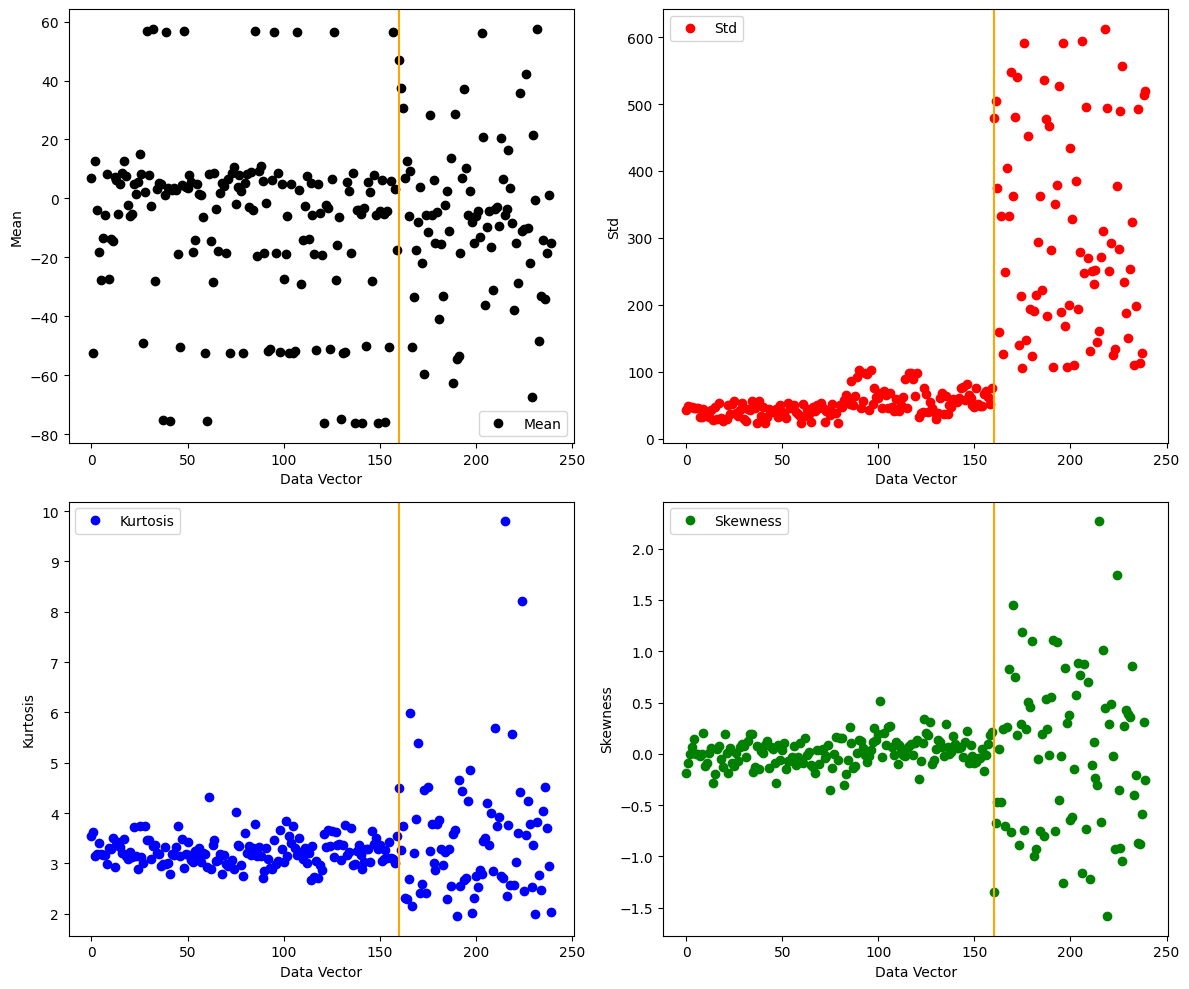

In [22]:
Extractor = EpilepsyFeatureExtractor()
Extractor.load_data()
Extractor.plot_stat_features()


(100, 4096)


100%|██████████| 240/240 [06:37<00:00,  1.65s/it]


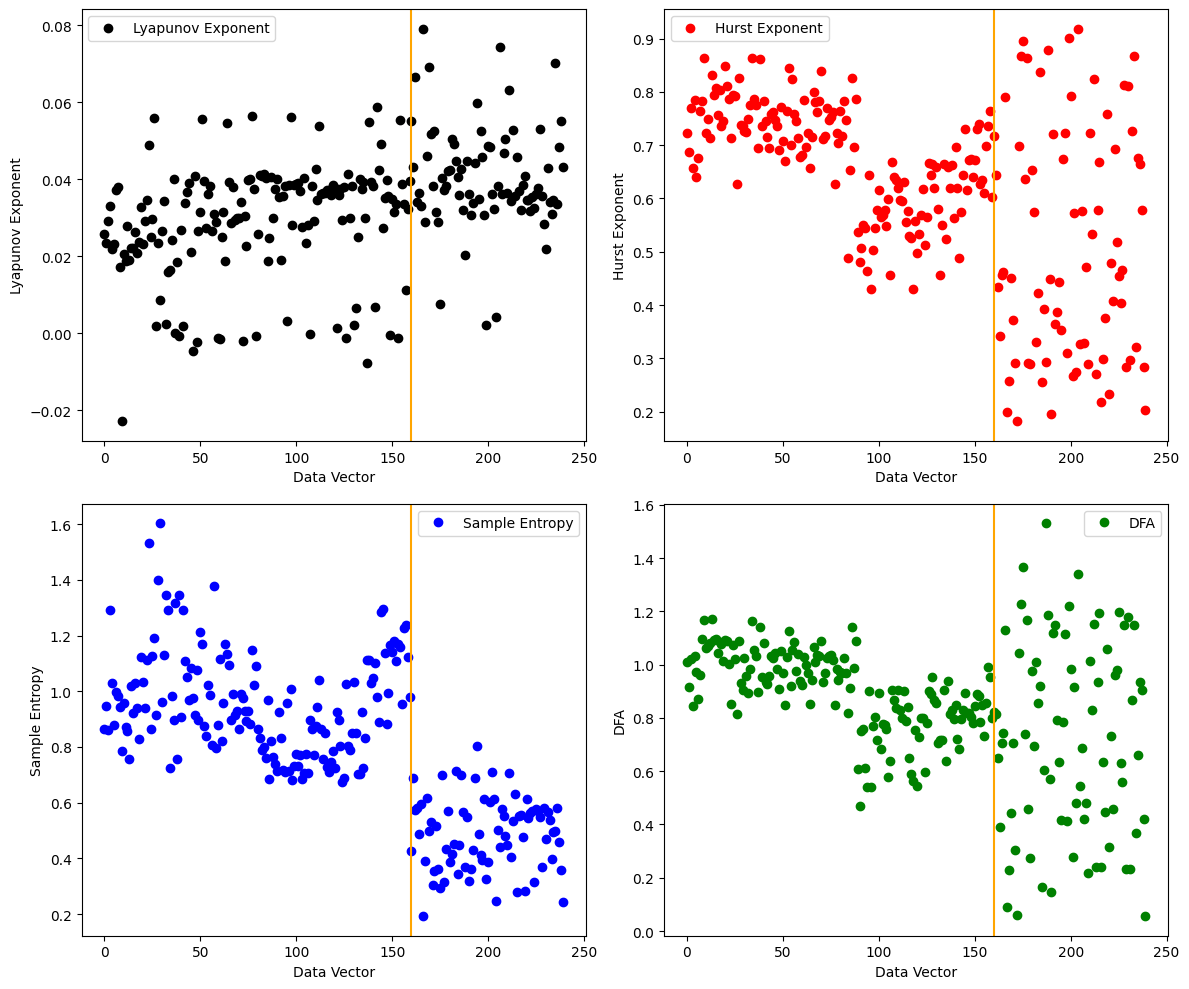

In [38]:
Extractor = EpilepsyFeatureExtractor()
Extractor.load_data()
Extractor.plot_chaotic_features()

(100, 4096)


100%|██████████| 240/240 [07:28<00:00,  1.87s/it]


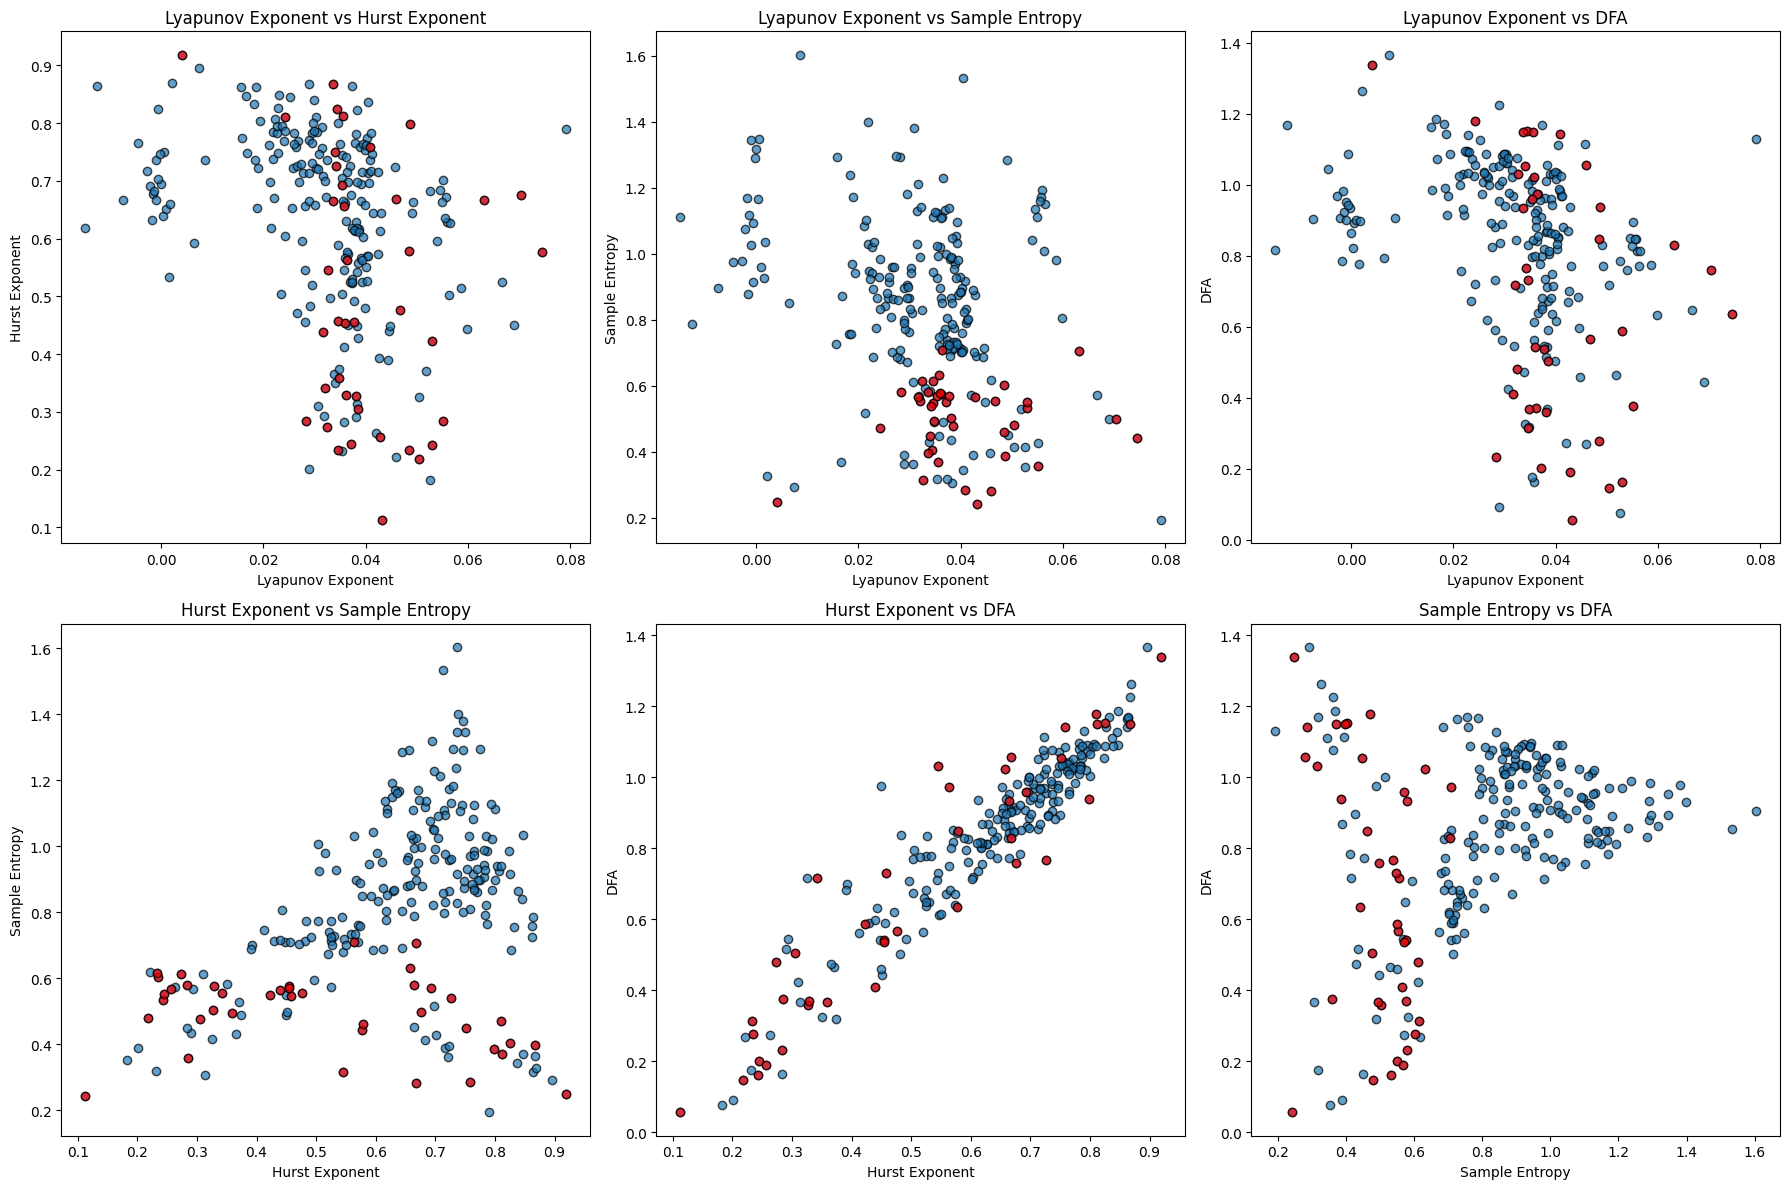

In [18]:
Extractor.plot_2d_features()


In [ ]:
extractor = EpilepsyFeatureExtractor()
extractor.load_data()
#Extract features to perform the classification.
stat_features = extractor.statistical_feature_extractor()
chaotic_features = extractor.chaotic_feature_extractor()

# Create labels: 0 for non-epileptic, 1 for epileptic
y = np.zeros(240)
y[160:] = 1  # The last 80 samples are epileptic

In [31]:
r_pipe = Pipeline([('clf', RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42))])

# Perform Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scores = cross_val_score(r_pipe, chaotic_features, y, cv=skf)

print('Cross-validation accuracy score = %1.3f (+/- %1.5f)' % (np.mean(scores), np.std(scores)))


(100, 4096)


100%|██████████| 240/240 [06:21<00:00,  1.59s/it]


Cross-validation accuracy score = 0.971 (+/- 0.00722)


In [32]:
s_pipe = Pipeline([('clf', svm.SVC())])

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

scores = cross_val_score(s_pipe, stat_features.T, y, cv=skf)
print('Cross-validation accuracy score = %1.3f (+/- %1.5f)' % (np.mean(scores),
                                                               np.std(scores)))                                                                                                   

Cross-validation accuracy score = 0.979 (+/- 0.02165)


In [34]:
s_pipe = Pipeline([('clf', svm.SVC())])

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

scores = cross_val_score(s_pipe, chaotic_features, y, cv=skf)
print('Cross-validation accuracy score = %1.3f (+/- %1.5f)' % (np.mean(scores),
                                                               np.std(scores)))  

Cross-validation accuracy score = 0.971 (+/- 0.00722)


In [37]:
k_pipe = Pipeline([('clf', KNeighborsClassifier(n_neighbors=1))])

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

scores = cross_val_score(k_pipe, stat_features.T, y, cv=skf)
print('Cross-validation accuracy score = %1.3f (+/- %1.5f)' % (np.mean(scores),
                                                               np.std(scores))) 

Cross-validation accuracy score = 1.000 (+/- 0.00000)


In [41]:
def run_classifiers(features, y):
    classifiers = {
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42),
        'SVM': svm.SVC(),
        'KNN': KNeighborsClassifier(n_neighbors=1)
    }

    results = []
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    for name, clf in classifiers.items():
        pipe = Pipeline([('clf', clf)])
        scores = cross_val_score(pipe, features, y, cv=skf)
        results.append({
            'Classifier': name,
            'Mean Accuracy': np.mean(scores),
            'Std Dev': np.std(scores)
        })

    return results

# Run classifiers on statistical features
stat_results = run_classifiers(stat_features.T, y)

# Run classifiers on chaotic features
chaotic_results = run_classifiers(chaotic_features, y)

# Combine statistical and chaotic features
combined_features = np.hstack((stat_features.T, chaotic_features))

# Run classifiers on combined features
combined_results = run_classifiers(combined_features, y)

# Combine results and create a DataFrame
all_results = pd.DataFrame(stat_results + chaotic_results + combined_results)
all_results['Feature Type'] = ['Statistical']*len(stat_results) + ['Chaotic']*len(chaotic_results) + ['Combined']*len(combined_results)

# Display the results
print(all_results)

     Classifier  Mean Accuracy   Std Dev Feature Type
0  RandomForest       0.995833  0.007217  Statistical
1           SVM       0.979167  0.021651  Statistical
2           KNN       1.000000  0.000000  Statistical
3  RandomForest       0.970833  0.007217      Chaotic
4           SVM       0.970833  0.007217      Chaotic
5           KNN       0.979167  0.013819      Chaotic
6  RandomForest       0.995833  0.007217     Combined
7           SVM       0.975000  0.018634     Combined
8           KNN       1.000000  0.000000     Combined
